**Bank Customer Segmentation**


In [22]:

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler
from  sklearn.cluster import KMeans 

import warnings
warnings.filterwarnings("ignore")



In [23]:
data = pd.read_csv('customers_data.csv')

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [24]:
data = data.drop(data.columns[0] , axis = 1)

In [25]:
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))

Database has 1000 obserwations (customers) and 9 columns (attributes).


In [26]:
print("Missing values in each column:\n{}".format(data.isnull().sum()))


Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


**Out of 8 columns 2 contain missing values. Probably these are customers who don’t have one of these two accounts.**


In [27]:
print("Column data types:\n {}".format(data.dtypes))

Column data types:
 Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


In [28]:
# unique values in each column 
n_unique = data.nunique()
print("Number of Unique Values:\n{}".format(n_unique))

Number of Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [29]:
print("Unique Values in each categorical column:")
for col in data.select_dtypes(include = [object]):
  print(col , ":" , data[col].unique())

Unique Values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Exploratory Data Analysis**

**Below I will define a function which will generate plots for three numeric variables with stratification by selected categorical column**.


In [30]:
def scatters(data , h=None , pal=None):
  fig , (ax1 , ax2 , ax3) = plt.subplots(3,1 )
  sns.scatterplot(x = "Credit amount" , y = "Duration" , hue = h , palette=pal , data=data , ax=ax2)
  sns.scatterplot(x = "Age" , y = "Credit amount" , hue = h , palette=pal , data=data , ax=ax1)
  sns.scatterplot(x = "Age" , y = "Duration" , hue = h , palette=pal , data=data , ax=ax3)
  plt.tight_layout()

**scatter plots stratified by Sex**


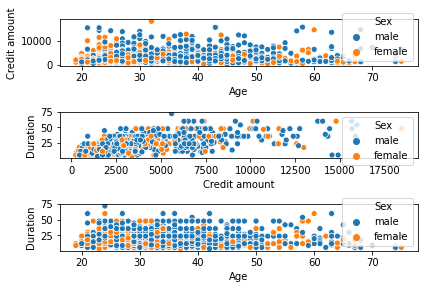

In [31]:

scatters(data , h = "Sex")

**From visual inspection, it seems that there is some positive correlation between duration and amount of credit.**

**check the linear correlation between credit amount and duration**

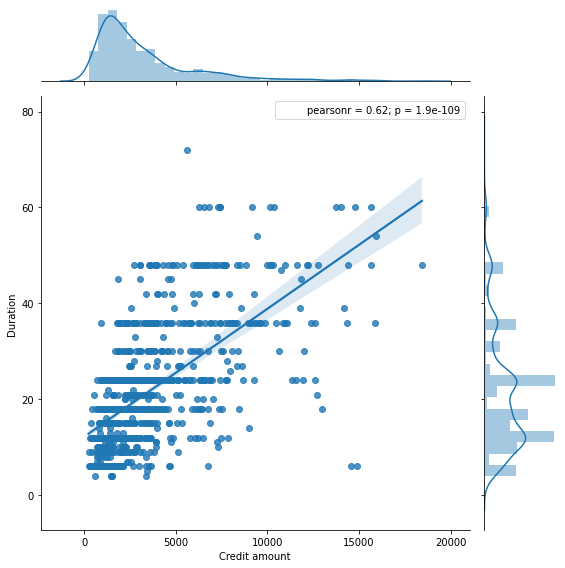

In [32]:
from scipy.stats import stats
r1 = sns.jointplot(x = "Credit amount" , y = "Duration" , kind = 'reg', height = 8 , data = data)
r1.annotate(stats.pearsonr)
plt.show()



**The plot above shows a linear correlation with Pearson value of 0.62 and very small p-value.**

**That make’s sense because usually, people take bigger credits for longer periods. Below I will analyse linear regression plots with various categorisations.** 


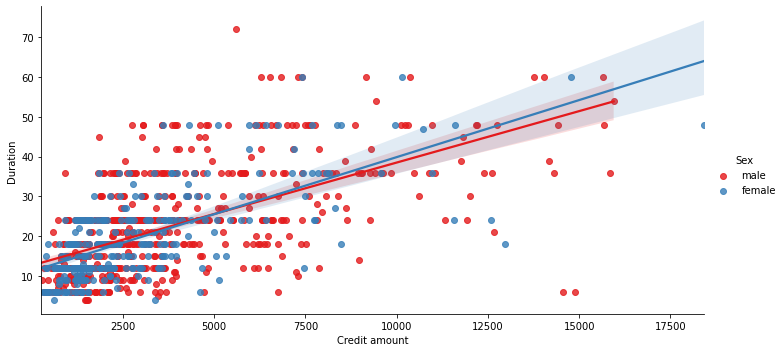

In [33]:
sns.lmplot(x = "Credit amount" , y = "Duration" , hue = "Sex" , data = data , aspect = 2 , palette= "Set1")
plt.show()

**The plot above indicates that there is no significant difference between men and women.**


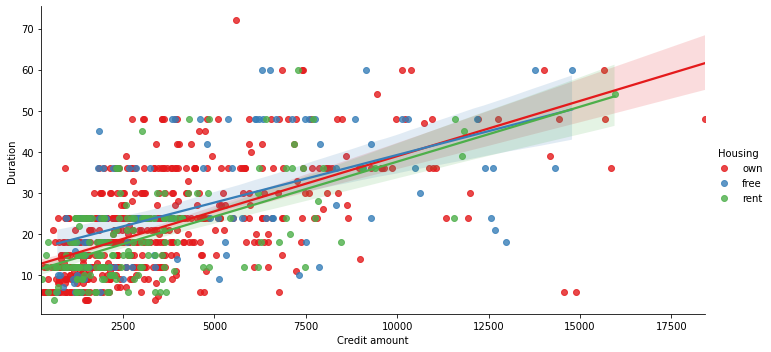

In [34]:
sns.lmplot(x = "Credit amount" , y = "Duration" , hue = "Housing" , data = data , aspect = 2 , palette= "Set1")
plt.show()


**The plot above shows similarly that there is no diference betwen housing categories.**

**“Business” area where the biggest amount of credits have been granted:**

In [35]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()

print(n_credits)


               Purpose  Count
0             business     97
1                  car    337
2  domestic appliances     12
3            education     59
4  furniture/equipment    181
5             radio/TV    280
6              repairs     22
7      vacation/others     12


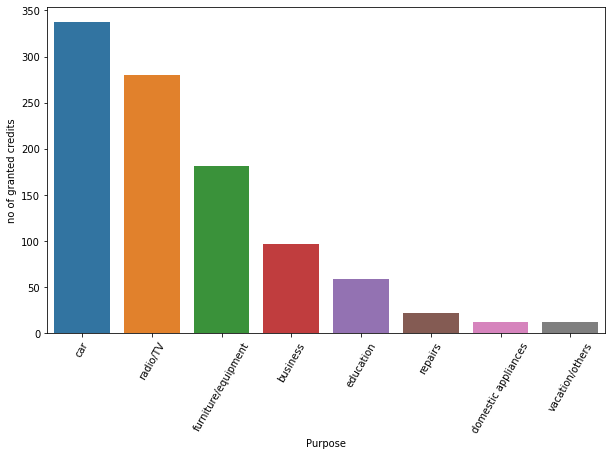

In [ ]:
n_credits = n_credits.sort_values(by=["Count"],ascending=False)
plt.figure(figsize=(10,6))

bar = sns.barplot(x="Purpose" , y = "Count" , data = n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation = 60)
plt.ylabel("no of granted credits")
plt.show()


**As per the graph above , most of the credits were for Car followed by radio/TV**

**Boxplots for detailed analysis of categorical variables**

In [36]:
def boxes(x,y,h,r=45):
    fig , ax = plt.subplots(figsize= (10,6))
    box = sns.boxplot(x=x, y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels() , rotation = r)
    fig.subplots_adjust(bottom = 0.2)
    plt.tight_layout()

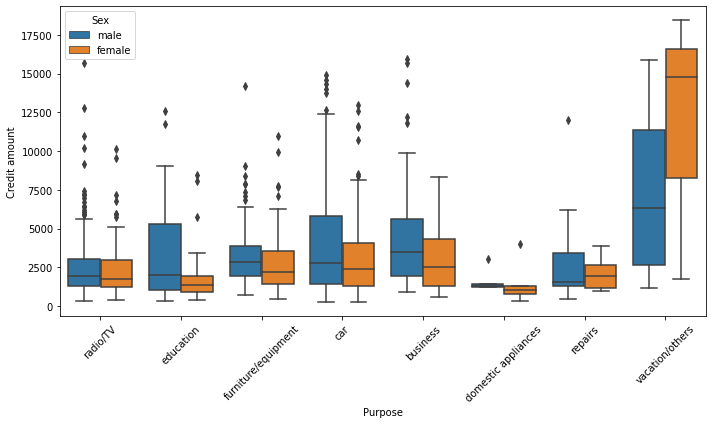

In [ ]:
boxes("Purpose" , "Credit amount" , "Sex")

**The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances.**
**In most of the cases there is no difference between men and women, despite category vacation/others.**
**There were very little number of credits granted in vacation/other category as per the count previously.** 


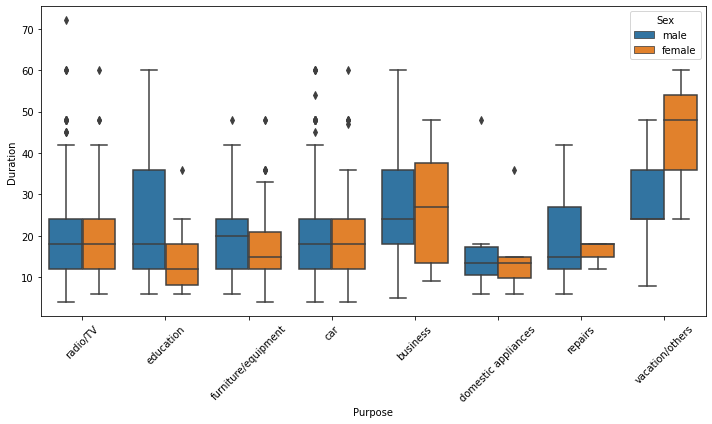

In [37]:
boxes("Purpose" , "Duration" , "Sex")

**The boxplot above indicates that generally there is no difference in credit duration between men and women.** 

**We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances.** 

**It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category,**
**there are the lowest amounts of credits.**  

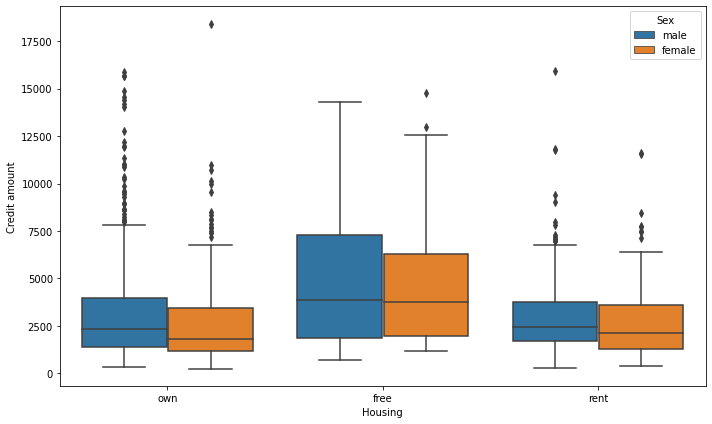

In [38]:
boxes("Housing" , "Credit amount" , "Sex" , r=0)

**In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts**

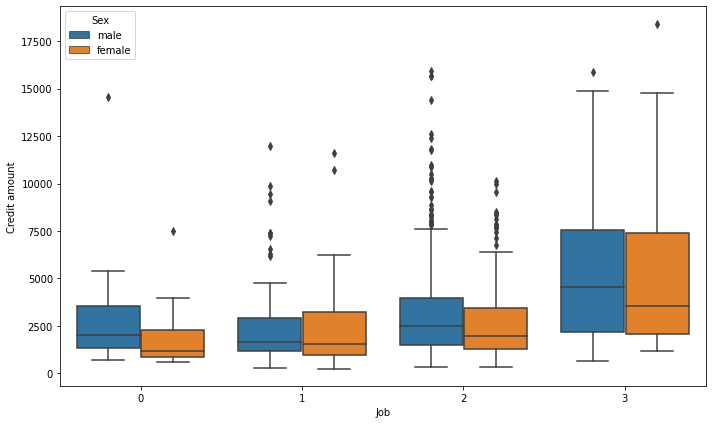

In [39]:
boxes("Job" , "Credit amount" , "Sex" , r=0)

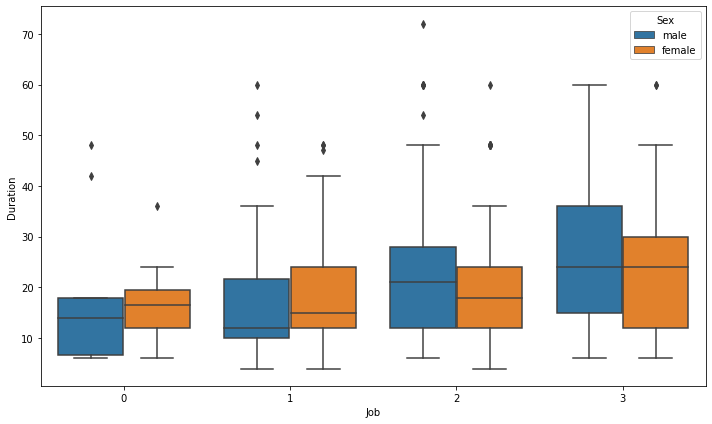

In [40]:
boxes("Job" , "Duration" , "Sex" , r=0)

**In terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer duration.**

In [41]:
#Selecting numeric colums for clusterisation with K-Means

selected_cols = ["Age" , "Credit amount" , "Duration"]
cluster_data = data.loc[: , selected_cols] 

**Creating a function that creates a histogram - for each of the three variables**


In [42]:
def distributions(df):
  fig , (ax1 , ax2 , ax3) = plt.subplots(3,1 , figsize = (8,8))
  sns.distplot(df["Age"] , ax = ax1)
  sns.distplot(df["Credit amount"] , ax = ax2)
  sns.distplot(df["Duration"] , ax = ax3)
  plt.tight_layout()


**The Three Histograms**


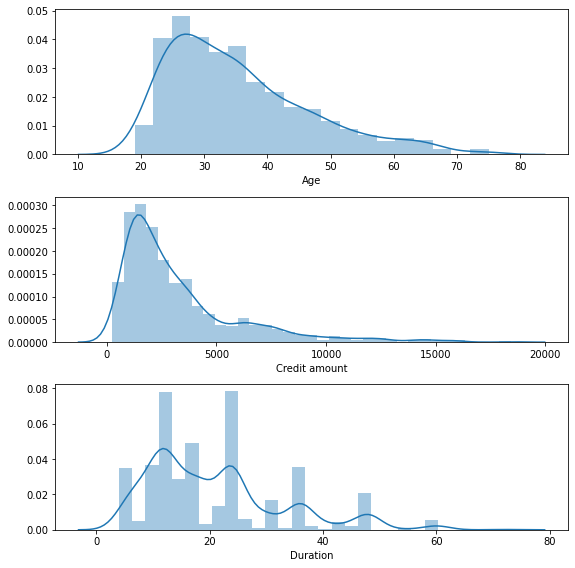

In [43]:
distributions(cluster_data)

**The above distributions are right skewed. To obtain better results , we should remove skewness by log transormation and then see the results**


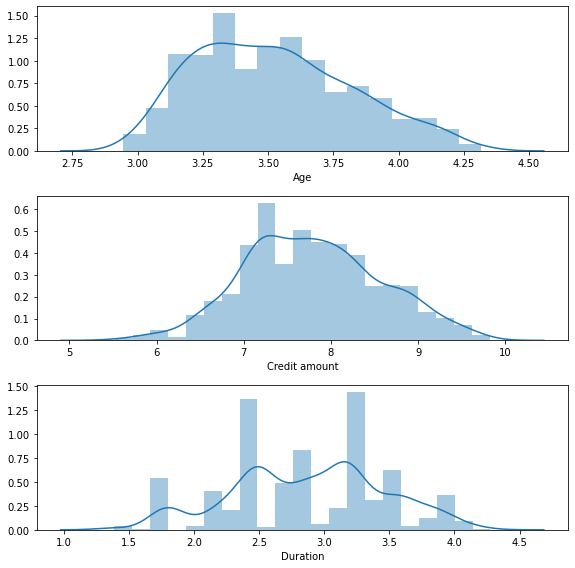

In [44]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

**The Skewness ha sbeen eliminated as per the graphs above.**

**The next step is centring and scaling of the variables - it is required for KMeans algorithm. We will use StandardScaler for sklearn library.**





In [45]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

**Checking how Inertia changes for various number of clusters - Elbow Method**


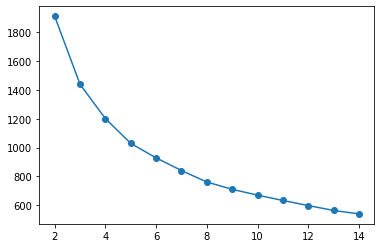

In [46]:
cluster_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertia = []

for c in cluster_range:
  kmeans = KMeans(n_clusters=c , random_state=0).fit(cluster_scaled)
  inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(cluster_range , inertia , marker = 'o') 


**The plot above shows that inertia decreases with increasing number of clusters.**

**This method allows for assessment of cluster separations and fitting of each observation in its own cluster. The highest score the better. I will perform this analysis for various seeds as well.**


In [47]:
from sklearn.metrics import silhouette_samples , silhouette_score
cluster_range = range(2,15)
seed_range = range(0,20)
results = []

for c in cluster_range:
  for s in seed_range:
    clusterer = KMeans(n_clusters = c , random_state = s)
    cluster_labels = clusterer.fit_predict(cluster_scaled)
    silhouette_avg = silhouette_score(cluster_scaled , cluster_labels)
    results.append([c,s, silhouette_avg])
    

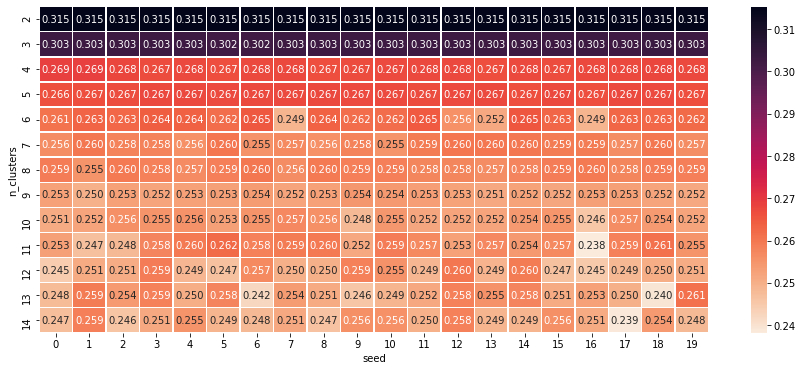

In [48]:
result = pd.DataFrame(results, columns=["n_clusters" , "seed" , "silhouette_score"])
pivot_km = pd.pivot_table(result , index = "n_clusters" , columns = "seed" , values="silhouette_score")

plt.figure(figsize = (15,6))
sns.heatmap(pivot_km , annot = True , linewidths = .5, cmap=sns.cm.rocket_r , fmt = '.3f')

**The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.**

**I will chose 3 clusters to get more insight into data**.'


**KMeans Clustering**


In [49]:
kmeans_sel = KMeans(n_clusters=3 , random_state = 1).fit(cluster_scaled) 
labels = pd.DataFrame(kmeans_sel.labels_)




In [50]:
clustered_data = cluster_data.assign(Cluster = labels)



 **I will define a function showing clusters on the scatter plot.**
 

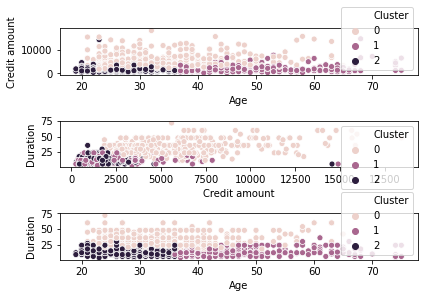

In [51]:

scatters(clustered_data , h = 'Cluster')

**Plots above show three created clusters. The first and third one show relatively clear separation of clusters, but it is no so evident on the second one.**

**I will generate now a heatmap plot for easier business interpretation of customer segmentation.**


In [52]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)

grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


**Conclusions:**

Cluster 0 – high mean of credit amount, long duration, middle-aged customers

Cluster 1 – lower mean of credit amount, short duration, older customers

Cluster 2 - lower mean of credit amount, short duration, young customers
